In [14]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# -----------------------------------
# Load CSV
# -----------------------------------
df = pd.read_csv("C:/Users/ADMIN/OneDrive - SAVIOUR/Desktop/projectEarthquake/Susceptability_pred_ML/EarthquakeFeatures.csv")
print("🔍 Columns found:", list(df.columns))

# -----------------------------------
# Step 1: Normalize FaultDensity (with NaN handling)
# -----------------------------------
df['FaultDensity_filled'] = df['FaultDensity'].fillna(0)  # Fill NaNs as 0 (sparse)
scaler_fd = MinMaxScaler()
df['fault_density_norm'] = scaler_fd.fit_transform(df[['FaultDensity_filled']])
joblib.dump(scaler_fd, "C:/Users/ADMIN/OneDrive - SAVIOUR/Desktop/projectEarthquake/Susceptability_pred_ML/fault_density_scaler.pkl")

# -----------------------------------
# Step 2: Identify and rename magnitude column
# -----------------------------------
mag_col = next((col for col in df.columns if col.lower().startswith('mag')), None)
if mag_col:
    df.rename(columns={mag_col: 'mag'}, inplace=True)
    print(f"✅ Using magnitude column: {mag_col}")
else:
    raise ValueError("❌ No column starting with 'mag' found.")

# -----------------------------------
# Step 3: Normalize HubDist and mag
# -----------------------------------
scaler_dist = MinMaxScaler()
scaler_mag = MinMaxScaler()
df['hub_dist_norm'] = scaler_dist.fit_transform(df[['HubDist']])
df['mag_norm'] = scaler_mag.fit_transform(df[['mag']])

# Save scalers
joblib.dump(scaler_dist, "C:/Users/ADMIN/OneDrive - SAVIOUR/Desktop/projectEarthquake/Susceptability_pred_ML/hubdist_scaler.pkl")
joblib.dump(scaler_mag, "C:/Users/ADMIN/OneDrive - SAVIOUR/Desktop/projectEarthquake/Susceptability_pred_ML/mag_scaler.pkl")

# Define known landslide-prone areas (based on region/fault names or place names)
landslide_prone_keywords = [
    "Joshimath", "Badrinath", "Kedarnath", "Chamoli", "Rudraprayag", "Pithoragarh", "Almora", "Nainital",
    "Manali", "Kullu", "Chamba", "Dharamshala", "Kangra",
    "Baramulla", "Pahalgam", "Uri", "Banihal", "Ramban",
    "Gangtok", "Mangan", "Chungthang", "Shillong", "Cherrapunji", "East Khasi Hills",
    "Kohima", "Wokha", "Itanagar", "Tawang", "Ziro",
    "Dima Hasao", "Karbi Anglong",
    "Idukki", "Wayanad", "Munnar", "Pathanamthitta", "Kottayam", "Ernakulam",
    "Kodagu", "Coorg", "Chikmagalur", "Uttara Kannada",
    "Nilgiris", "Ooty", "Coonoor",
    "Darjeeling"," Dehradun"," Mussoorie", "Rishikesh", "Haridwar", "Tehri"
]

# -----------------------------------
# Step 4: Compute 0–5 safety rating
# -----------------------------------
def compute_rating(row):
    # Initial normalized weighted risk score
    risk = (
        0.3 * (1 - row['hub_dist_norm']) +
        0.3 * row['fault_density_norm'] +
        0.4 * row['mag_norm']
    )

    # Raw values
    fault_density_raw = row['FaultDensity']
    hub_dist_raw = row['HubDist']
    mag_raw = row['mag']

    # -------------------------------
    # Penalization Conditions
    # -------------------------------
    
    # (1) Strong penalty for critical danger despite low fault density
    if (pd.isna(fault_density_raw) or fault_density_raw <= 0.05):
        if hub_dist_raw <= 50000 or mag_raw >= 5.5:
            risk += 0.4  # major penalty

    # (2) Moderate penalty for medium danger zone
    if hub_dist_raw <= 100000 or mag_raw >= 4.0:
        risk += 0.2  # medium penalty

    # (3) Light penalty for elevated risk even if data sparse
    if mag_raw >= 3.5 or hub_dist_raw <= 150000:
        risk += 0.1
    
    # (4) Terrain-based penalty (landslide-prone zones)
    hub_name = row.get('HubName', '')
    if isinstance(hub_name, str) and any(keyword.lower() in hub_name.lower() for keyword in landslide_prone_keywords):
        risk += 0.15  # Terrain penalty


    # -------------------------------
    # Safety rating (0 = Unsafe, 5 = Very Safe)
    # -------------------------------
    rating = 5.0 - (risk * 5.0)
    return round(max(0.0, min(5.0, rating)), 2)

df['safety_rating'] = df.apply(compute_rating, axis=1)

# -----------------------------------
# Step 5: Assign safety labels
# 0 = Safe, 1 = Moderate, 2 = Unsafe
# -----------------------------------
def assign_label(rating):
    if rating >= 2.5:
        return 0  # Safe
    elif rating >= 1.25:
        return 1  # Moderate
    else:
        return 2  # Unsafe

df['label'] = df['safety_rating'].apply(assign_label)

# -----------------------------------
# Step 6: Save the labeled dataset
# -----------------------------------
output_path = "C:/Users/ADMIN/OneDrive - SAVIOUR/Desktop/projectEarthquake/Susceptability_pred_ML/earthquakes_labeled.csv"
df.to_csv(output_path, index=False)

print("✅ Final labeled dataset saved.")
print("🔍 NaN check (should be 0):")
print(df[['FaultDensity', 'fault_density_norm', 'safety_rating']].isna().sum())


🔍 Columns found: ['X', 'Y', 'OBJECTID', 'SOURCE', 'YR', 'MO', 'DT', 'HR', 'MN', 'SEC', 'LAT', 'LONG_', 'MAGMB', 'DEPTH_KM', 'MW', 'HubName', 'HubDist', 'FaultDensity']
✅ Using magnitude column: MAGMB
✅ Final labeled dataset saved.
🔍 NaN check (should be 0):
FaultDensity          14072
fault_density_norm        0
safety_rating             0
dtype: int64


In [15]:
print("📊 Safety Rating Distribution Summary:")
print(df['safety_rating'].describe())

📊 Safety Rating Distribution Summary:
count    16495.000000
mean         1.467585
std          1.075556
min          0.000000
25%          0.000000
50%          1.700000
75%          1.990000
max          4.790000
Name: safety_rating, dtype: float64


🔍 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       453
           1       0.99      0.99      0.99      1781
           2       0.99      0.99      0.99      1065

    accuracy                           0.99      3299
   macro avg       0.99      0.99      0.99      3299
weighted avg       0.99      0.99      0.99      3299



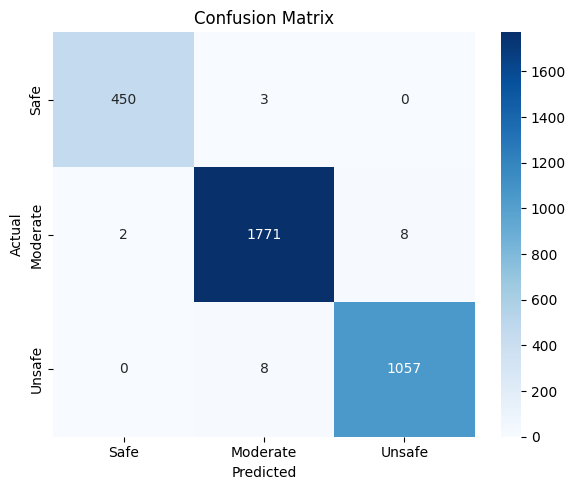

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the labeled data
landslide_prone_keywords = [
    "Joshimath", "Badrinath", "Kedarnath", "Chamoli", "Rudraprayag", "Pithoragarh", "Almora", "Nainital",
    "Manali", "Kullu", "Chamba", "Dharamshala", "Kangra",
    "Baramulla", "Pahalgam", "Uri", "Banihal", "Ramban",
    "Gangtok", "Mangan", "Chungthang", "Shillong", "Cherrapunji", "East Khasi Hills",
    "Kohima", "Wokha", "Itanagar", "Tawang", "Ziro",
    "Dima Hasao", "Karbi Anglong",
    "Idukki", "Wayanad", "Munnar", "Pathanamthitta", "Kottayam", "Ernakulam",
    "Kodagu", "Coorg", "Chikmagalur", "Uttara Kannada",
    "Nilgiris", "Ooty", "Coonoor",
    "Darjeeling"," Dehradun"," Mussoorie", "Rishikesh", "Haridwar", "Tehri"
]
df = pd.read_csv("earthquakes_labeled.csv")
df['terrain_penalty'] = df['HubName'].apply(lambda h: 1 if str(h).lower() in landslide_prone_keywords else 0)
df['has_fault_density'] = df['fault_density_norm'].apply(lambda x: 0 if pd.isna(x) or x < 0.05 else 1)

features = ['mag', 'HubDist', 'fault_density_norm', 'has_fault_density', 'terrain_penalty']
X = df[features]
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save model and feature names
joblib.dump((model, features), "EarthquakePredictor.pkl")

y_pred = model.predict(X_test)

# Classification report
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Safe', 'Moderate', 'Unsafe']  # Adjust if different in your dataset

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()